## Bike Sharing Demand
### Forecast use of a city bikeshare system

(Kaggle competition link: https://www.kaggle.com/c/bike-sharing-demand/overview)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/bike-sharing-demand/.~lock.sampleSubmission.csv#
kaggle/input/bike-sharing-demand/train.csv
kaggle/input/bike-sharing-demand/test.csv
kaggle/input/bike-sharing-demand/sampleSubmission.csv


In [2]:
from sklearn import model_selection, linear_model, ensemble, pipeline, preprocessing, metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Loading data:

In [4]:
# Reading the train data and test data
raw_data = pd.read_csv('kaggle/input/bike-sharing-demand/train.csv')
raw_val = pd.read_csv('kaggle/input/bike-sharing-demand/test.csv')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
raw_val.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Description of data features:
***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

## Data inspection:

In [7]:
print(raw_data.shape, raw_val.shape)

(10886, 12) (6493, 9)


In [8]:
raw_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
raw_val.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [11]:
raw_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [12]:
# Correlation 
raw_data.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


(11.0, 0.0)

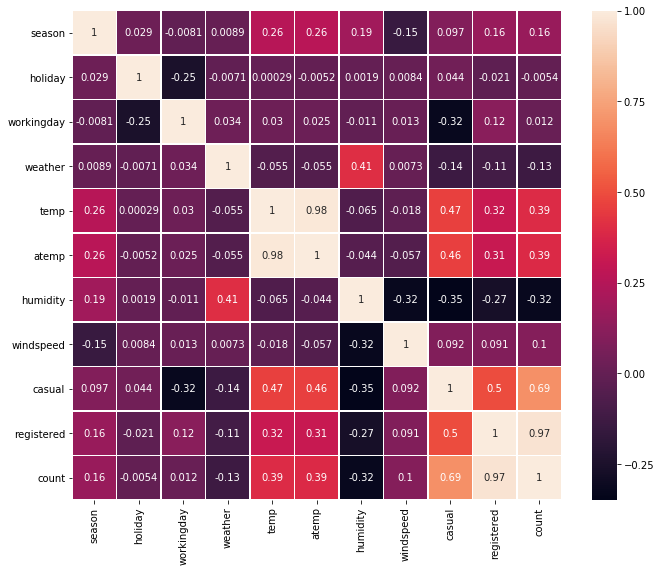

In [13]:
# Visualusation of correlation 
corr = raw_data.corr()
plt.figure(figsize=(11, 9))
ax = sns.heatmap(corr, square=True,annot=True,cbar=True, linewidths=.5)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

## Data preprocessing:

In [14]:
# Features 'registered', 'casual' and target variable 'count'
# have a strong linear dependence (a+b=c)
np.all(raw_data.registered + raw_data.casual == raw_data['count'])

True

In [15]:
# Converting column to datetime type 
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
raw_val.datetime = raw_val.datetime.apply(pd.to_datetime)

In [16]:
# Adding new columns - month, hour and year
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)
raw_data['year'] = raw_data.datetime.apply(lambda x : x.year)

raw_val['month'] = raw_val.datetime.apply(lambda x : x.month)
raw_val['hour'] = raw_val.datetime.apply(lambda x : x.hour)
raw_val['year'] = raw_val.datetime.apply(lambda x : x.year)

In [17]:
# Delelting of ununnecessary features
raw_data = raw_data.drop(['datetime', 'casual', 'registered'], axis=1)
val_data = raw_val.drop(['datetime'], axis=1)

In [18]:
# Dividing to train sample and label sample
data_labels = raw_data['count']
data = raw_data.drop(['count'], axis=1)

In [19]:
# Spliting data into random train and test subsets
X_train, X_test, y_train, y_test = model_selection.train_test_split(data,
                                                                    data_labels,
                                                                    test_size=0.1,
                                                                    random_state=42)

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9797, 11) (1089, 11) (9797,) (1089,)


In [21]:
# Noticing colums with different type of features
binary_col = ['holiday', 'workingday']
numeric_col = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
categor_col = ['season', 'weather', 'month', 'year']

# Function for getting index of columns (for FunctionTransformer)
def get_ind(names_col):
    return [X_train.columns.get_loc(i) for i in names_col]

Encoding, scaling, polymerization will be in pipelines

## Linear regression (SGD):

In [23]:
# Choosing a model
sgd_reg = linear_model.SGDRegressor(random_state=42)

In [24]:
# Creating pipeline for data transforming and further estimation
sgd_estimator = pipeline.Pipeline(steps=[
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[
        
        #binary
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data:\
                                                                          data[:, get_ind(binary_col)])),
        
        #numeric
        ('numeric_variables_processing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, get_ind(numeric_col)])),
            ('scaling', preprocessing.StandardScaler(with_mean=0.))])),
        
        #categorical
        ('categorical_variables_processing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, get_ind(categor_col)])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))])),
        ])),
    
    ('model_fitting', sgd_reg)
])

In [25]:
# Available parametrs of created estimator
print(*sgd_estimator.get_params().keys(), sep='\n')

memory
steps
verbose
feature_processing
model_fitting
feature_processing__n_jobs
feature_processing__transformer_list
feature_processing__transformer_weights
feature_processing__verbose
feature_processing__binary_variables_processing
feature_processing__numeric_variables_processing
feature_processing__categorical_variables_processing
feature_processing__binary_variables_processing__accept_sparse
feature_processing__binary_variables_processing__check_inverse
feature_processing__binary_variables_processing__func
feature_processing__binary_variables_processing__inv_kw_args
feature_processing__binary_variables_processing__inverse_func
feature_processing__binary_variables_processing__kw_args
feature_processing__binary_variables_processing__pass_y
feature_processing__binary_variables_processing__validate
feature_processing__numeric_variables_processing__memory
feature_processing__numeric_variables_processing__steps
feature_processing__numeric_variables_processing__verbose
feature_processing_

In [26]:
# Variation of paramers for grid_search
parametrs_sgd = {'model_fitting__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1],
                 'model_fitting__eta0' : [0.001, 0.05, 0.1, 0.5], # initial gradient step
                 'model_fitting__max_iter' : [500, 1000, 2000],
                 'model_fitting__penalty' : ['l2']}

In [27]:
# Available scores of grid_search
print(*metrics.SCORERS.keys(), sep='\n')

explained_variance
r2
max_error
neg_median_absolute_error
neg_mean_absolute_error
neg_mean_squared_error
neg_mean_squared_log_error
accuracy
roc_auc
balanced_accuracy
average_precision
neg_log_loss
brier_score_loss
adjusted_rand_score
homogeneity_score
completeness_score
v_measure_score
mutual_info_score
adjusted_mutual_info_score
normalized_mutual_info_score
fowlkes_mallows_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
recall
recall_macro
recall_micro
recall_samples
recall_weighted
f1
f1_macro
f1_micro
f1_samples
f1_weighted
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted


In [28]:
# Choosing grid_search for searching best model's parametrs and cross-validation
grid_cv_sgd = model_selection.GridSearchCV(sgd_estimator,
                                           parametrs_sgd,
                                           scoring='neg_mean_absolute_error',
                                           cv=5,
                                           n_jobs=-1)

In [29]:
%%time
# Fiting grid_search by data
grid_cv_sgd.fit(X_train, y_train)

CPU times: user 5.8 s, sys: 1.56 s, total: 7.35 s
Wall time: 3min 1s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feature_processing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(accept_sparse=False,
                                                                                            check_inverse=True,
                                                                                            func=<function <lambda> at 0x7f191c3a03b0>,
                                                                                            inv_kw_args=None,
                                                                                            inverse_func=None,
                                                                                          

In [30]:
print(grid_cv_sgd.best_score_)
print(grid_cv_sgd.best_params_)

-105.37707430364274
{'model_fitting__alpha': 0.1, 'model_fitting__eta0': 0.001, 'model_fitting__max_iter': 500, 'model_fitting__penalty': 'l2'}


In [31]:
def get_rmsle(y_true, y_pred):
    '''Func for counting Root Mean Squared Logarithmic Error (RMSLE)'''
    
    # scaling to (0. 1)
    y_true_scaled = preprocessing.minmax_scale(y_true,feature_range=(0,1))    
    y_pred_scaled = preprocessing.minmax_scale(y_pred, feature_range=(0,1))
    
    return np.sqrt(metrics.mean_squared_log_error(y_true_scaled,
                                                  y_pred_scaled))

In [32]:
y_train_pred_sgd = grid_cv_sgd.best_estimator_.predict(X_train)

In [33]:
# RMSLE on train data
print('RMSLE on train data: {}'.format(get_rmsle(y_train, y_train_pred_sgd)))

RMSLE on train data: 0.2843820949906415


#### score on test data:

In [34]:
y_test_pred_sgd = grid_cv_sgd.best_estimator_.predict(X_test)

In [35]:
# RMSLE on test data
print('RMSLE on test data: {}'.format(get_rmsle(y_test, y_test_pred_sgd)))

RMSLE on test data: 0.27756788833375284


In [36]:
# compare several test labels and predicted labels just by view 
print(y_test[:13].to_numpy())
print(y_test_pred_sgd[:13].round())

[127  13 163 233 222 166 144 376 601  53   6  14 209]
[238.  37. 169. 269. 372. 285. 167. 294. 157.  49.   4. 137. 278.]


Text(0.5, 1.0, 'SGD Regressor')

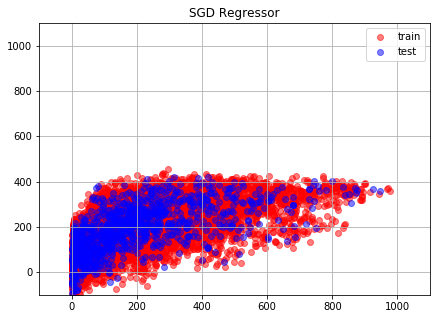

In [37]:
# Display a graph of points in the space of correct labels and predictions 
# on train and test data. A diagonal cloud of point is expected for a good regression model.\
# (2 scatter plots on 1 graph)
plt.figure(figsize=(7, 5))
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(y_train, y_train_pred_sgd, alpha=0.5, color='red', label='train')
plt.scatter(y_test, y_test_pred_sgd, alpha=0.5, color='blue', label='test')
plt.legend()
plt.title('SGD Regressor')

So, the linear model SGD Regressor showed not really impressive result.

## Random Forest:

In [38]:
# Choosing a model
rf_reg = ensemble.RandomForestRegressor(random_state=42)

In [39]:
# Creating pipeline for data transforming and further estimation
# (notice: numeric data doesn't need scaling with random forest, but just let it be)
rf_estimator = pipeline.Pipeline(steps=[
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[
        
        #binary
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data:\
                                                                          data[:, get_ind(binary_col)])),
        
        #numeric
        ('numeric_variables_processing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, get_ind(numeric_col)])),
            ('scaling', preprocessing.StandardScaler(with_mean=0.))])),        
        
        #categorical
        ('categorical_variables_processing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, get_ind(categor_col)])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False))])),
        ])),
    
    ('model_fitting', rf_reg)
])

In [40]:
# Available parametrs of created estimator
print(*rf_estimator.get_params().keys(), sep='\n')

memory
steps
verbose
feature_processing
model_fitting
feature_processing__n_jobs
feature_processing__transformer_list
feature_processing__transformer_weights
feature_processing__verbose
feature_processing__binary_variables_processing
feature_processing__numeric_variables_processing
feature_processing__categorical_variables_processing
feature_processing__binary_variables_processing__accept_sparse
feature_processing__binary_variables_processing__check_inverse
feature_processing__binary_variables_processing__func
feature_processing__binary_variables_processing__inv_kw_args
feature_processing__binary_variables_processing__inverse_func
feature_processing__binary_variables_processing__kw_args
feature_processing__binary_variables_processing__pass_y
feature_processing__binary_variables_processing__validate
feature_processing__numeric_variables_processing__memory
feature_processing__numeric_variables_processing__steps
feature_processing__numeric_variables_processing__verbose
feature_processing_

In [41]:
# Variation of paramers for grid_search
rf_parametrs = {'model_fitting__n_estimators' : [500, 1000],
                'model_fitting__max_depth' : [20, 60]}

In [42]:
# Choosing grid_search for searching best model's parametrs and cross-validation
grid_cv_rf = model_selection.GridSearchCV(rf_estimator,
                                          rf_parametrs,
                                          scoring='neg_mean_absolute_error',
                                          cv=5,
                                          n_jobs=-1)

In [43]:
%%time
# Fiting grid_search by data
grid_cv_rf.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 1.47 s, total: 1min 24s
Wall time: 15min 26s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feature_processing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(accept_sparse=False,
                                                                                            check_inverse=True,
                                                                                            func=<function <lambda> at 0x7f191c5f58c0>,
                                                                                            inv_kw_args=None,
                                                                                            inverse_func=None,
                                                                                          

In [131]:
print(grid_cv_rf.best_score_)
print(grid_cv_rf.best_params_)

-28.03255980785525
{'model_fitting__max_depth': 20, 'model_fitting__n_estimators': 1000}


In [132]:
# Dirty hack for getting column name of train data after scalling in order to
# counting feature's importances (see below)
temp_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)
temp_train_X_encoded = temp_encoder.fit_transform(X_train[categor_col])
temp_column_name = temp_encoder.get_feature_names(categor_col)
temp_X_train_drop = X_train.drop(categor_col, axis=1)
train_column_names = np.concatenate([np.array(list(temp_X_train_drop)), temp_column_name])

In [133]:
# Let's see which features are most important
feature_importances = grid_cv_rf.best_estimator_.named_steps['model_fitting'].feature_importances_

# puting features and their importances into DataFrame
feature_importan_df = pd.DataFrame({'feature' : train_column_names, 
                                    'feature_importances' : feature_importances.round(4)})
# showing importance of features (first ten)
feature_importances_df = feature_importan_df.sort_values('feature_importances',
                                                         ascending=False).head(10)
feature_importances_df

,feature,feature_importances
6,hour,0.6103
2,temp,0.0850
1,workingday,0.0716
27,year_2011,0.0433
28,year_2012,0.0417
3,atemp,0.0373
4,humidity,0.0321
7,season_1,0.0272
13,weather_3,0.0127
5,windspeed,0.0112


In [136]:
# Another dirty hack for getting all scalling train data with column name in order to
# shoing plot of dependence of the most important features from count (see below)
one_hot_encoded_data = X_train
for cat in categor_col:      
    temp_one_hot_encoded_data = pd.get_dummies(X_train[cat],prefix=cat)    
    one_hot_encoded_data = pd.concat([one_hot_encoded_data,temp_one_hot_encoded_data],axis=1)
    one_hot_encoded_data.drop(cat, axis=1, inplace=True)  

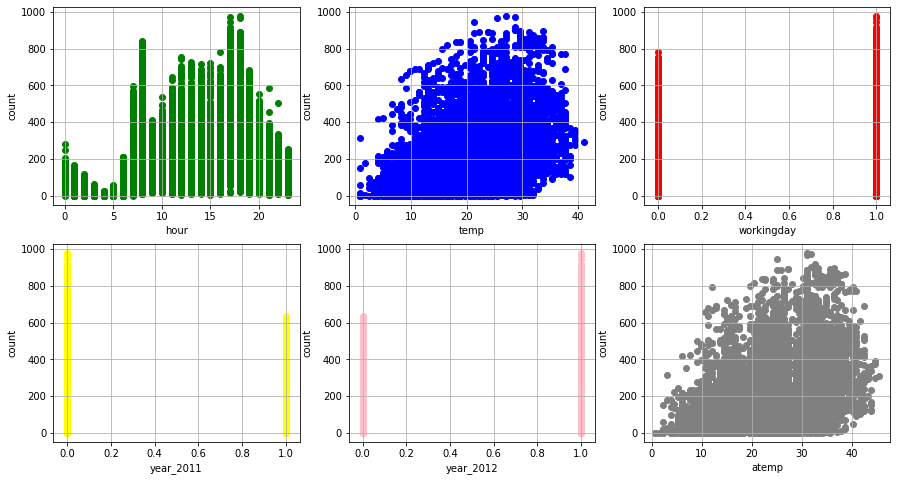

In [137]:
# Plot of dependence of the most important features from count
plt.figure(figsize=(15, 8))
colors = ['green', 'blue', 'red', 'yellow', 'pink', 'grey']
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.grid(True)
    plt.scatter(one_hot_encoded_data[feature_importances_df.iloc[i, 0]],
                y_train, color=colors[i], label='train')    
    plt.ylabel('count')
    plt.xlabel(feature_importances_df.iloc[i, 0])

In [138]:
# RMSLE on train data
y_train_pred = grid_cv_rf.best_estimator_.predict(X_train)
print('RMSLE on train data: {}'.format(get_rmsle(y_train, y_train_pred)))

RMSLE on train data: 0.01588275162953303


#### score on test data:

In [139]:
# RMSLE on test data
y_test_pred = grid_cv_rf.best_estimator_.predict(X_test)
print('RMSLE on test data: {}'.format(get_rmsle(y_test, y_test_pred)))

RMSLE on test data: 0.03429178034789059


In [140]:
# compare several test labels and predicted labels just by view 
print(y_test[:13].to_numpy())
print(y_test_pred[:13].round())

[127  13 163 233 222 166 144 376 601  53   6  14 209]
[136.  12. 145. 211. 170. 182. 140. 364. 665.  61.   8.  30. 219.]


Text(0.5, 1.0, 'Random Forest')

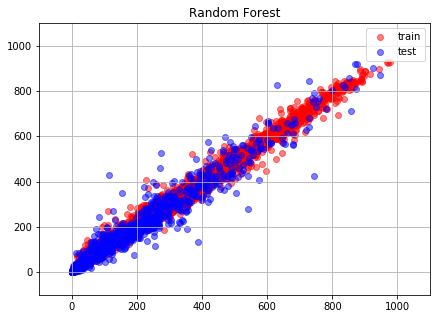

In [141]:
# Display a graph of points in the space of correct labels and predictions 
# on train and test data. A diagonal cloud of point is expected for a good regression model.
# (2 scatter plots on 1 graph)
plt.figure(figsize=(7, 5))
plt.grid(True)
plt.xlim(-100,1100)
plt.ylim(-100,1100)
plt.scatter(y_train, y_train_pred, alpha=0.5, color = 'red', label='train')
plt.scatter(y_test, y_test_pred, alpha=0.5, color = 'blue', label='test')
plt.legend()
plt.title('Random Forest')

So, the Random Forest Regressor showed better result.

### Final prediction and submision:

In [142]:
# Predictions on validation sample
y_val_pred = grid_cv_rf.best_estimator_.predict(val_data)

In [143]:
# Making submission file (saving results in the csv-file)
answer = pd.DataFrame({'datetime' : raw_val.datetime,
                       'count' : y_val_pred})
answer.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
